# Distribution of vegetation in a landscape of heterogeneous predation risk

In [1]:
# importing libraries

import numpy as np
from matplotlib import pyplot as plt
import math
from itertools import permutations as perm
import time
from matplotlib import animation as animate

# Notebook parameters

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 20

## Defining initialisation functions

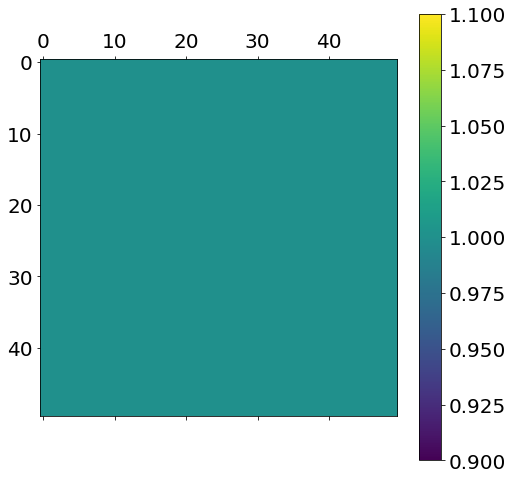

In [2]:
# Defining resource matrix

def veg(N):
    
    # Starting with resoource available everywhere
    
    V = np.full((N, N), 1)

    return V

# test plot

plt.matshow(veg(50))
plt.colorbar()

In [3]:
# Creating list of fish in the landscape

def fish_vec(n, N):

    # n = initial number of fish
    # N = size of the landscape

    # Iniital position at the center

    x = int(N/2); y = int(N/2)

    # Data for a single fish

    fish = np.array([(x,y), 0], # [(position), starvation time]
    dtype='object')

    fish_pop = np.full((n,2), fish, dtype='object')

    return fish_pop

# test

print(fish_vec(5, 50))

[[(25, 25) 0]
 [(25, 25) 0]
 [(25, 25) 0]
 [(25, 25) 0]
 [(25, 25) 0]]


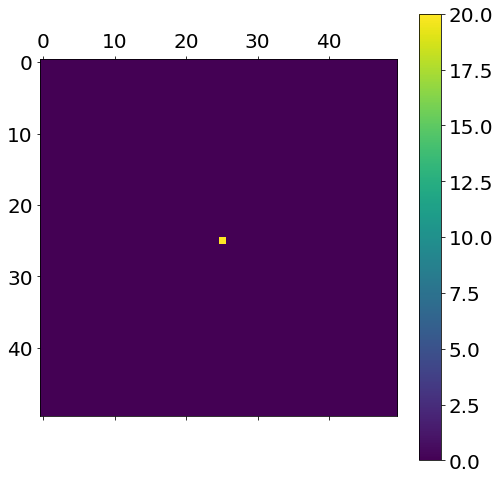

In [4]:
# summarising fish density in the landscape

def fish_mat(fish_pop, N):

    # creating an empty matrix for fish

    F =  np.zeros((N, N))

    # Extracting fish positioins

    fish_pos = fish_pop[:,0]

    # Summing number of fish in each cell

    for index, value in np.ndenumerate(F):

        for f in fish_pos:

            if index == f:

                F[index] += 1

    return F

# test

fish_pop = fish_vec(20, 50)

plt.matshow(fish_mat(fish_pop, 50))
plt.colorbar()

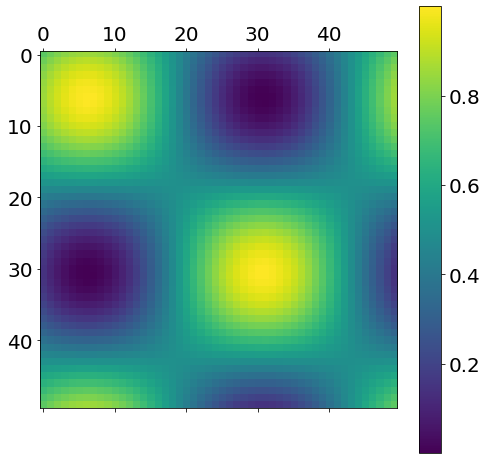

In [5]:
# Predation risk as a function of space

def risk(ix, iy, N):

    # Period

    k = 1

    # Amplitude

    a = 1

    b = 1

    alpha =  a*math.sin(2*math.pi*k*(ix + iy)/(N - 1)) + b*math.cos(2*math.pi*k*(ix - iy)/(N - 1)) + a + b

    # normalisation

    alpha = alpha/(4*a)

    return alpha

# test

N = 50

x = list(range(N))
y = list(range(N))

index = 0 

alpha = [0]*50*50

for ix in x:

    for iy in y:

        alpha[index] =  risk(ix, iy, N)

        index += 1

alpha = np.array(alpha)

alpha = np.reshape(alpha, (50, 50))

plt.matshow(alpha)
plt.colorbar()

## Defining update functions

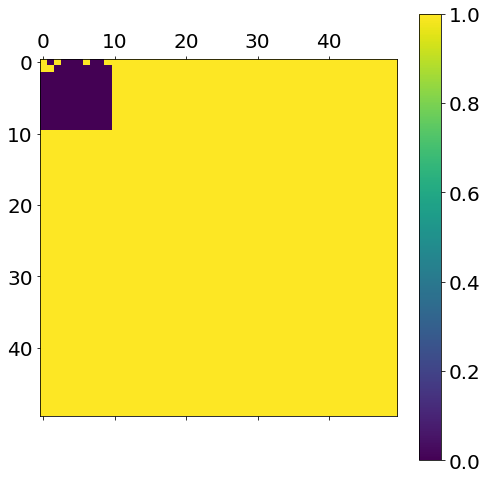

In [6]:
# spread and regeneration of vegetation

def veg_update(veg_mat):

    N = np.shape(veg_mat) # getting shape of vegetation matrix

    for index, value in np.ndenumerate(veg_mat):

        if value == 0:

            adj = [] # empty list of adjascent cells

            # getting list of adjascent cells

            for dx in [-1, 0, 1]:

                for dy  in [-1, 0, 1]:

                    x = index[0] + dx # horizontal

                    y = index[1] + dy # vertical

                    # Periodic boundaries

                    if x > N[0]-1 and y > N[1]-1:

                         x = x - N[0] - 1

                         y = y - N[1] - 1
                         
                         adj.append((x,y))

                    elif x > N[0]-1 or y > N[1]-1:

                        if x > N[0]-1:

                            x = x - N[0] - 1

                            adj.append((x, y))
                        
                        else:

                            y = y - N[1] - 1

                            adj.append((x, y))

                    else:
                
                        adj.append((x, y))

            # Spread of vegetation

            ## Getting values from adjascent cells

            adj_veg = []

            for cell in adj:

                adj_veg.append(veg_mat[cell])
            
            ## checking if neighbours are present

            if all(x == 0 for x in adj_veg):

                break
            
            else:
                
                # updating value 

                veg_mat[index] = int(np.random.choice(a = [0,1], p =  [0.5, 0.5])) # p = 0.5

    return(veg_mat)

# Test

V = veg(50)

for dx in range(10):

    for dy in range(10):

        V[dx, dy] = 0

V = veg_update(V)

plt.matshow(V)
plt.colorbar()


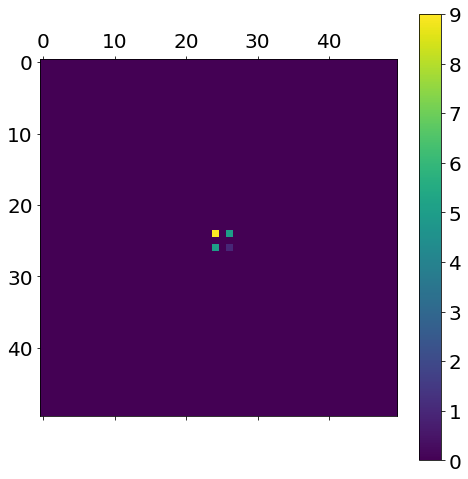

In [7]:
# updating fish positions

def fish_mov(fish_pop, risk_mat):

    index = 0

    for f in fish_pop:

        # Periodic boundaries

        x = f[0][0]
        y = f[0][1]

        if x >= 49:

            x = abs(x) - 49

            if y >= 49:

                y = abs(y) - 49
    
        elif y >= 49:

            y = abs(y) - 49
        
        # Calculating risk

        xrisk = (risk(x+1, y, 50) - risk(x-1, y, 50))/2
        yrisk = (risk(x, y+1, 50) - risk(x, y-1, 50))/2

        # Calculating moves based on risk

        px =  0.5 - xrisk # Risk of moving right vs left
        py =  0.5 - yrisk # risk of moving up vs down

        # 2 - D risk - biased random walk

        dx = x + np.random.choice(a = [-1,1], p = [(1-px), px])
        dy = y + np.random.choice(a = [-1,1], p = [(1-py), py])

        # Periodic boundaries

        if dx >= 49:

            dx = abs(dx) - 49

            if dy >= 49:

                dy = abs(dy) - 49
    
        elif dy >= 49:

            dy = abs(dy) - 49

        fish_pop[index][0] = (dx, dy)

        index += 1

    return fish_pop

# Test

fish_pop = fish_vec(20, 50)

fish_t1 = fish_mov(fish_pop, alpha)

plt.matshow(fish_mat(fish_t1, 50))
plt.colorbar()

In [8]:
# Fish reproduction

def fish_rep(fish_pop):

    for f in fish_pop:

        rep = np.random.choice(a = [0,1], p = [0.99, 0.01]) # P(reproduce) = 0.01

        if rep == 1:

            f[1] = 0 #resetting starvation clock

            fish_pop = np.append(fish_pop, [f], axis = 0)
    
    return fish_pop


# Test

fish_pop = fish_vec(20, 50)

print(len(fish_rep(fish_pop)))

22


In [9]:
# Fish starvation

def fish_starve(fish_pop):
    
    index = 0

    idx = []

    for f in fish_pop:

        # At t_S = 10, fish dies

        if f[1] == 10:

            idx.append(index)
        
        else:

            # Starvation clock increases with each time step

            fish_pop[index, 1] = fish_pop[index, 1] + 1

        index += 1
    
    # Killing fish

    fish_pop = np.delete(fish_pop, idx, axis = 0)

    return fish_pop

# Test

fish_pop = fish_vec(20, 50)

for t in range(12):

    fish_pop = fish_starve(fish_pop)

    print(len(fish_pop))


20
20
20
20
20
20
20
20
20
20
0
0


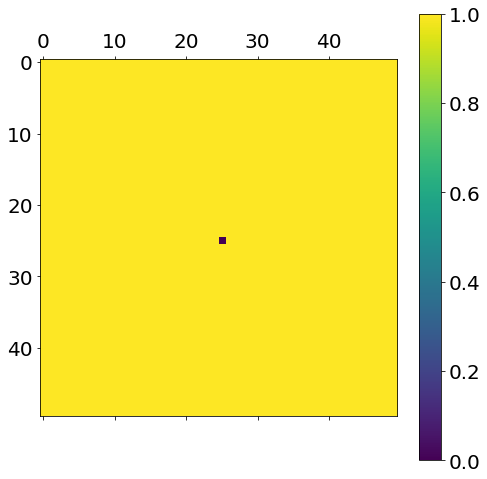

In [10]:
# Fish feeding

def fish_feed(fish_pop, veg_mat):

    index = 0

    for f in fish_pop:

        # Check if vegetation is present

        if veg_mat[f[0]] == 1:

            # Fish eats the vegetations 

            # Veg disappears

            veg_mat[f[0]] = 0

            # Fish starvation clock starts over

            fish_pop[index, 1] = 0
        
        index += 1
    
    return veg_mat, fish_pop

# Test

fish_pop = fish_vec(20, 50)

veg_mat = veg(50)

veg_mat, fish_pop = fish_feed(fish_pop, veg_mat)

plt.matshow(veg_mat)
plt.colorbar()


## Simulating 

In [11]:
# Defining simulation parameters

T_max = 500 # time for the simulation
N = 50 # length of side for N x N matrix
n = 100 # initial number of fish

In [12]:
# Initialising the landscape

fish_pop = fish_vec(n, N) # fish population
veg_mat = veg(N) # resource matrix

In [13]:
# Results

fish_abn = [0]*T_max # fish abundance
veg_abn = [0]*T_max # resource abundance

veg_res = np.zeros((N, N, T_max+2))
veg_res[:,:,0] = veg_mat

fish_res = np.zeros((N, N, T_max+2))
fish_res[:,:,0] = fish_mat(fish_pop, N)


In [14]:
# Simulation

for t in range(T_max):

    # Updating resource values

    veg_mat = veg_update(veg_mat)

    # Fish feeding

    veg_mat, fish_pop = fish_feed(fish_pop, veg_mat)

    # Fish starvation and death

    fish_pop = fish_starve(fish_pop)

    # Fish reproduce

    fish_pop = fish_rep(fish_pop)

    # Fish movement

    fish_pop = fish_mov(fish_pop, alpha)

    # Logging fish abundance

    fish_abn[t] = len(fish_pop)

    fish_res[:,:,t+1] = fish_mat(fish_pop, N)

    # Logging resource

    veg_abn[t] = np.sum(veg_mat)

    veg_res[:,:,t+1] = veg_mat




Breaks for long simulation in either `fish_mov` or `fish_feed`

MovieWriter ffmpeg unavailable; using Pillow instead.


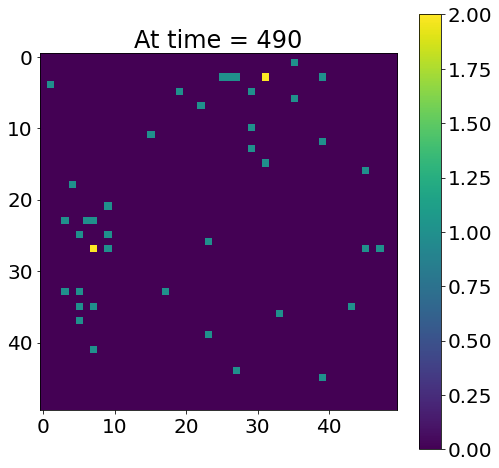

In [15]:
# Animating fish movement in the landscape

def lilly(slice):

    plt.clf()
    plt.imshow(fish_res[:,:,slice*10])
    plt.colorbar()
    plt.title(f"At time = {slice*10}")

anim = animate.FuncAnimation(plt.figure(), lilly, range(T_max//10), interval = 1000)

anim.save("sim1.gif")

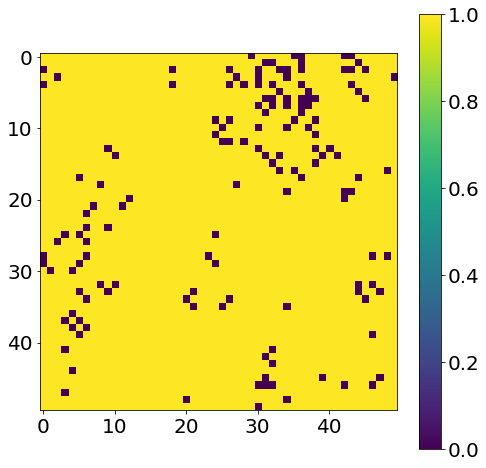

In [16]:
# Final vegetation distribution

plt.imshow(veg_mat)
plt.colorbar()

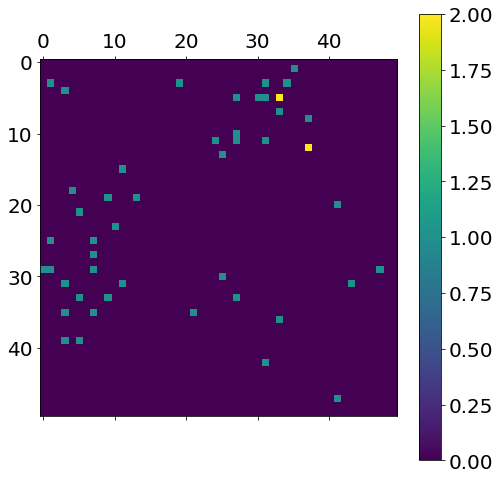

In [17]:
# Final fish distribtion

plt.matshow(fish_mat(fish_pop, N))
plt.colorbar()

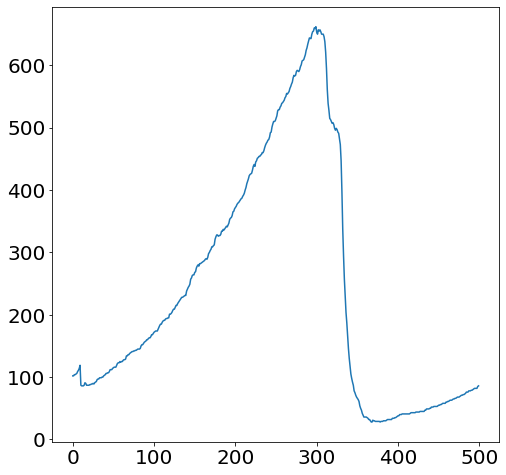

In [18]:
# Abudnance of fish over time

plt.plot(range(T_max), fish_abn)

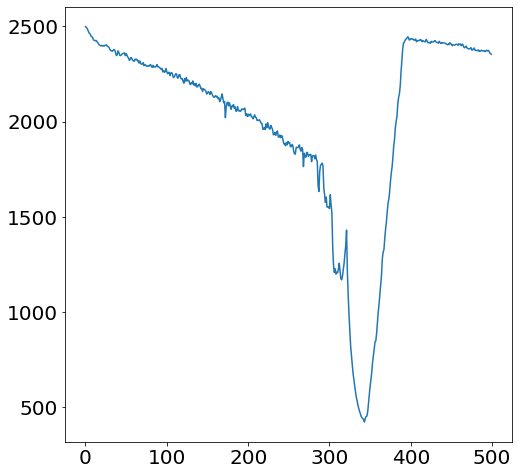

In [19]:
# Abundance of resource over time

plt.plot(range(T_max), veg_abn)